## Algorithm 1: Scheme of subtasks for tree detection and diameter calculation.

in linux


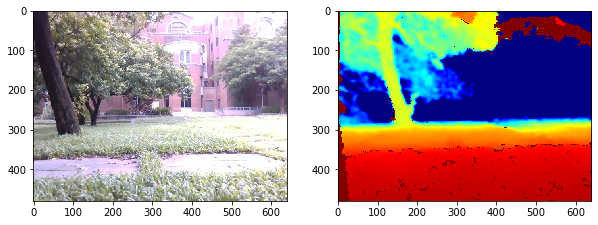

In [74]:
'''math tool'''
import csv
import numpy as np
from scipy.spatial import distance as dist

'''plot tool'''
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.ticker as ticker

'''image tool'''
import cv2
#import pyrealsense2 as rs
import statistics as sta

import utm
from pyproj import Proj
import sys
if sys.platform.startswith('linux'): # or win
    print("in linux")
    file_path = "/home/ncslaber//mapping_node/mapping_ws/src/mapping_explorer/test_data/"
#     sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
else:
    file_path = r"C:/Users/15sin/OneDrive/文件/GitHub/mapping_explorer/test_data/"

npDepth = np.load(file_path+"depth.npy")
npColor = np.load(file_path+"color.npy")

npDepthF = cv2.convertScaleAbs(npDepth, alpha=0.02) # 6m
npDepthF_color = cv2.applyColorMap(npDepthF, cv2.COLORMAP_JET)
fig=plt.figure(figsize=(10,10))
subplot = fig.add_subplot(121)
subplot.imshow(npColor)
subplot = fig.add_subplot(122)
subplot.imshow(npDepthF_color)

## Algorithm 2: Detection of trees in point clouds.

### 1. at different heights hi, slices of thickness t, project all points within onto a plane li parallel to xy-plane

In [3]:
def depth_Z(u,v):
    return npDepth[v][u]

cx_d = 320.6562194824219 #424
cy_d = 241.57083129882812 #241
fx_d = 384.31365966796875 #424
fy_d = 384.31365966796875 #424

float16


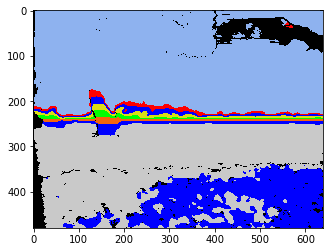

In [4]:
npPointX = np.asarray(range(640))-cx_d
npPointX = np.diag(npPointX)
npPointX = npDepth.dot(npPointX)/ fx_d * (-1)

npPointY = np.asarray(range(480))-cy_d
npPointY = np.diag(npPointY)
theta = 0/180*np.pi
npPointY = npPointY.dot(npDepth)/ fy_d * (-1) 
npPointY = npPointY*np.cos(theta) + npDepth * np.sin(theta) + 410
npPointY = npPointY.astype('float16')

'''depth segmentation'''
npHeight = np.copy(npPointY)
color_seq = {'brown': (0,130,210), 'red':(0,0,255),'yellow':(22,220,220),
                'green':(0,255,0), 'blue':(255,0,0),'black':(0,0,0), 
                'gray':(201,201,201), 'orange':(13,101,245), 'sky':(239,178,142) }
npHeight_seg = np.zeros((npDepth.shape[0],npDepth.shape[1],3))

npHeight_seg[npHeight<-50]=color_seq['gray']
npHeight_seg[np.logical_and(npHeight<300,npHeight>-50)]=color_seq['blue']
npHeight_seg[np.logical_and(npHeight<500,npHeight>300)]=color_seq['orange']
npHeight_seg[np.logical_and(npHeight<700,npHeight>500)]=color_seq['green']
npHeight_seg[np.logical_and(npHeight<900,npHeight>700)]=color_seq['yellow']
npHeight_seg[np.logical_and(npHeight<1100,npHeight>900)]=color_seq['blue']
npHeight_seg[np.logical_and(npHeight<1300,npHeight>1100)]=color_seq['red']
npHeight_seg[npHeight>1300]=color_seq['sky']
npHeight_seg[npHeight==410]=color_seq['black']
# npHeight_seg[np.logical_and(npHeight<0.9,npHeight>-0.9)]=(255,255,255)
# print(*(npDepth[np.logical_and(npHeight<0.9,npHeight>-0.9)]))
print(npHeight.dtype)
npHeight_seg = npHeight_seg.astype('uint8')
%matplotlib inline
plt.imshow(cv2.cvtColor(npHeight_seg, cv2.COLOR_BGR2RGB))


### case01: in the middle (orange area)

(125, 75)

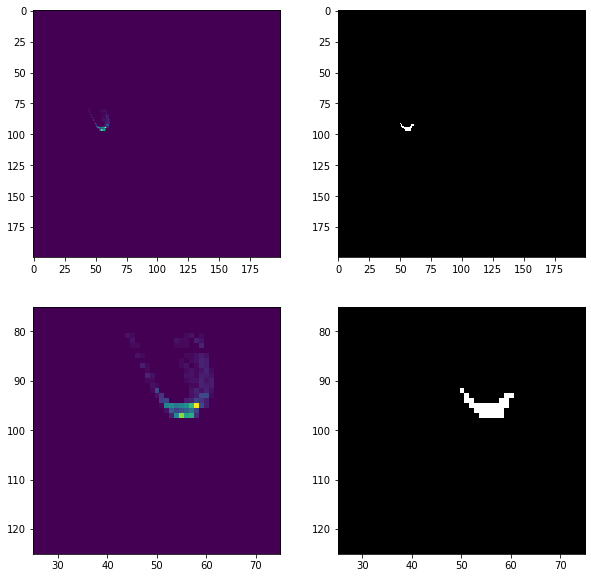

In [5]:
height_layer_tmp = np.logical_and(npHeight<500,npHeight>300)
height_layer = np.logical_and(height_layer_tmp,npHeight!=410)

plane_l1 = np.zeros((int(10/0.05),int(10/0.05)),dtype=np.uint8)

row, column = npDepth.shape
scan_height_ = 10
center_y = row/2
offset = int(center_y - scan_height_/2 );

for v in range(row):#, offset+scan_height_,1
    if height_layer[v].any() == True:
        for u in range(column):
            if height_layer[v][u] == True:
                z_depth = depth_Z(u,v)

                if (z_depth>50 and z_depth<6000):
                    x_depth = (u-cx_d)/fx_d*depth_Z(u,v)
                    plane_l1[200-int(z_depth/50)][int(x_depth/50)+100]+=1
                
    else:
        pass

fig=plt.figure(figsize=(10,10))
subplot = fig.add_subplot(221)
subplot.imshow(plane_l1)

plane_l1_copy = np.zeros((int(10/0.05),int(10/0.05)), dtype=np.uint8)
plane_l1_copy[plane_l1>4]=255
subplot = fig.add_subplot(222)
subplot.imshow(cv2.cvtColor(plane_l1_copy, cv2.COLOR_BGR2RGB))

subplot = fig.add_subplot(223)
subplot.imshow(plane_l1)
plt.xlim((25,75))
plt.ylim((125,75))
subplot = fig.add_subplot(224)
subplot.imshow(cv2.cvtColor(plane_l1_copy, cv2.COLOR_BGR2RGB))
plt.xlim((25,75))
plt.ylim((125,75))

### check if correct

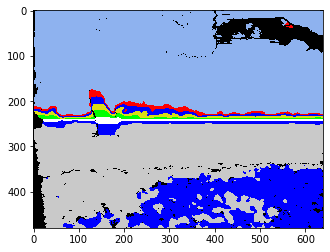

In [6]:
# mark white
npHeight_seg[height_layer]=255
plt.imshow(cv2.cvtColor(npHeight_seg, cv2.COLOR_BGR2RGB))

### case02: different layer (green area)

In [6]:
import time

(125, 75)

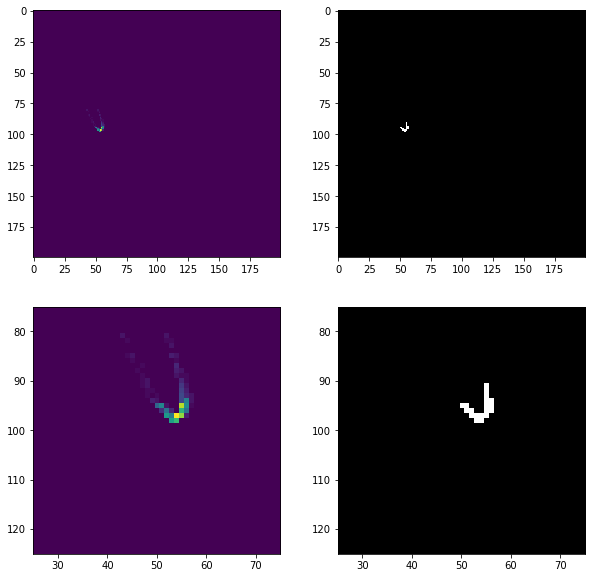

In [7]:
height_layer = np.logical_and(npHeight<700,npHeight>500)

plane_l2 = np.zeros((int(10/0.05),int(10/0.05)),dtype=np.uint8)

row, column = npDepth.shape

for v in range(row):#, offset+scan_height_,1
    if height_layer[v].any() == True:
        for u in range(column):
            if height_layer[v][u] == True:
                z_depth = depth_Z(u,v)
                if (z_depth>50 and z_depth<6000):
                    x_depth = (u-cx_d)/fx_d*depth_Z(u,v)
                    plane_l2[200-int(z_depth/50)][int(x_depth/50)+100]+=1
    else:
        pass

fig=plt.figure(figsize=(10,10))
subplot = fig.add_subplot(221)
subplot.imshow(plane_l2)

plane_l2_copy = np.zeros((int(10/0.05),int(10/0.05)), dtype=np.uint8)
plane_l2_copy[plane_l2>4]=255
subplot = fig.add_subplot(222)
subplot.imshow(cv2.cvtColor(plane_l2_copy, cv2.COLOR_BGR2RGB))

subplot = fig.add_subplot(223)
subplot.imshow(plane_l2)
plt.xlim((25,75))
plt.ylim((125,75))
subplot = fig.add_subplot(224)
subplot.imshow(cv2.cvtColor(plane_l2_copy, cv2.COLOR_BGR2RGB))
plt.xlim((25,75))
plt.ylim((125,75))

(125, 75)

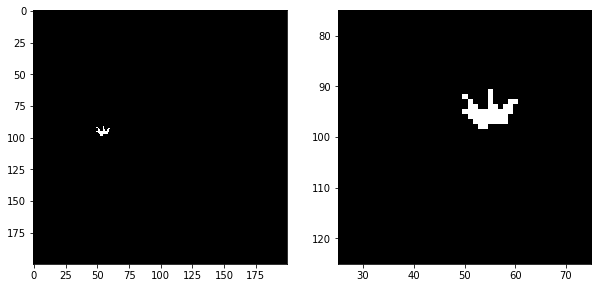

In [8]:
hieght_or = np.zeros((int(10/0.05),int(10/0.05)), dtype=np.uint8)
hieght_or[np.logical_or(plane_l1_copy,plane_l2_copy)]=255

fig = plt.figure(figsize=(10,10))
subplot = fig.add_subplot(121)
subplot.imshow(cv2.cvtColor(hieght_or, cv2.COLOR_BGR2RGB))
subplot = fig.add_subplot(122)
subplot.imshow(cv2.cvtColor(hieght_or, cv2.COLOR_BGR2RGB))
plt.xlim((25,75))
plt.ylim((125,75))

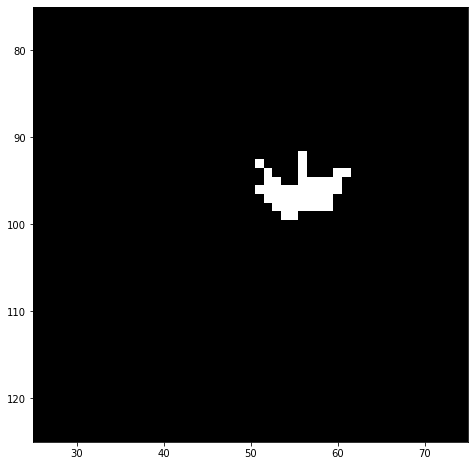

In [9]:
hieght_or = hieght_or.astype('uint8')
kernel = np.ones((2,2), np.uint8)
hieght_or = cv2.dilate(hieght_or,kernel,iterations = 1)
hieght_or = cv2.erode(hieght_or, kernel, iterations = 1)

fig.ax = plt.subplots(figsize=(8,8))
plt.xlim((25,75))
plt.ylim((125,75))
plt.imshow(cv2.cvtColor(hieght_or, cv2.COLOR_BGR2RGB))

### The circle equation

In [10]:
A = []
for x in range(int(10/0.05)):
    for y in range(int(10/0.05)):
        if hieght_or[x][y] != 0:
            A.append(np.array([-x/(x*x+y*y), -y/(x*x+y*y), -1/(x*x+y*y)]))
A = np.asarray(A)
print(A.shape)

k = np.linalg.inv(A.T @ A)
k = k @ A.T
k = k @ np.ones((k.shape[1],1))
# print(k)

(41, 3)


In [11]:
centre_x = k[0][0]/(-2)
centre_y = k[1][0]/(-2)
radius_r = np.sqrt(centre_x*centre_x+centre_y*centre_y-k[2][0])
print(centre_x, centre_y, radius_r)
print(int(centre_x), int(centre_y), int(radius_r+0.5))

95.03975510235705 55.65475641053786 3.3191304419292376
95 55 3


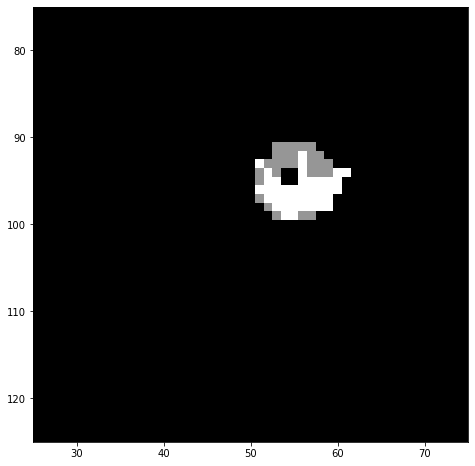

In [12]:
circle_bd = np.zeros(hieght_or.shape, dtype=np.uint8)
cv2.circle(circle_bd,(int(centre_y), int(centre_x)), int(radius_r+0.5), 150, 2)
circle_bd[hieght_or==255]=255
fig.ax = plt.subplots(figsize=(8,8))
plt.xlim((25,75))
plt.ylim((125,75))

plt.imshow(cv2.cvtColor(circle_bd, cv2.COLOR_BGR2RGB))

## Anothor case: connected component labelling

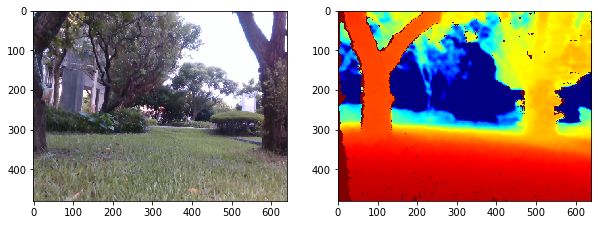

In [13]:
npDepth = np.load(file_path+"depth_2tree.npy")
npColor = np.load(file_path+"color_2tree.npy")

npDepthF = cv2.convertScaleAbs(npDepth, alpha=0.02) # 6m
npDepthF_color = cv2.applyColorMap(npDepthF, cv2.COLORMAP_JET)
fig=plt.figure(figsize=(10,10))
subplot = fig.add_subplot(121)
subplot.imshow(npColor)
subplot = fig.add_subplot(122)
subplot.imshow(npDepthF_color)

float16


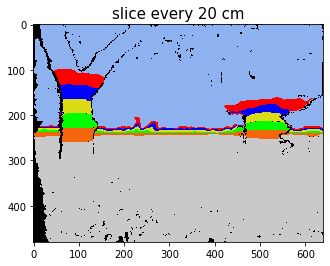

In [28]:
npPointX = np.asarray(range(640))-cx_d
npPointX = np.diag(npPointX)
npPointX = npDepth.dot(npPointX)/ fx_d * (-1)

npPointY = np.asarray(range(480))-cy_d
npPointY = np.diag(npPointY)
theta = 0/180*np.pi
npPointY = npPointY.dot(npDepth)/ fy_d * (-1) 
npPointY = npPointY*np.cos(theta) + npDepth * np.sin(theta) + 410
npPointY = npPointY.astype('float16')

'''depth segmentation'''
npHeight = np.copy(npPointY)
color_seq = {'brown': (0,130,210), 'red':(0,0,255),'yellow':(22,220,220),
                'green':(0,255,0), 'blue':(255,0,0),'black':(0,0,0), 
                'gray':(201,201,201), 'orange':(13,101,245), 'sky':(239,178,142) }
npHeight_seg = np.zeros((npDepth.shape[0],npDepth.shape[1],3))

npHeight_seg[npHeight<300]=color_seq['gray']
npHeight_seg[np.logical_and(npHeight<500,npHeight>300)]=color_seq['orange']
npHeight_seg[np.logical_and(npHeight<700,npHeight>500)]=color_seq['green']
npHeight_seg[np.logical_and(npHeight<900,npHeight>700)]=color_seq['yellow']
npHeight_seg[np.logical_and(npHeight<1100,npHeight>900)]=color_seq['blue']
npHeight_seg[np.logical_and(npHeight<1300,npHeight>1100)]=color_seq['red']
npHeight_seg[npHeight>1300]=color_seq['sky']
npHeight_seg[npHeight==410]=color_seq['black']
# npHeight_seg[np.logical_and(npHeight<0.9,npHeight>-0.9)]=(255,255,255)
# print(*(npDepth[np.logical_and(npHeight<0.9,npHeight>-0.9)]))
print(npHeight.dtype)
npHeight_seg = npHeight_seg.astype('uint8')
%matplotlib inline
plt.title('slice every 20 cm', fontsize=15)
plt.imshow(cv2.cvtColor(npHeight_seg, cv2.COLOR_BGR2RGB))

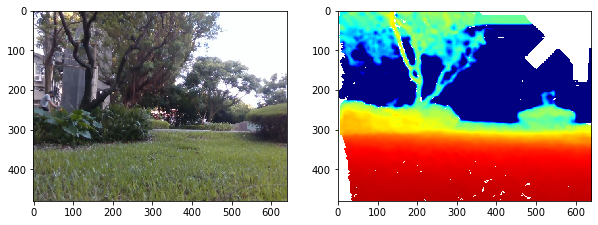

In [8]:
npDepth = np.load(file_path+"depth_with_shrub1.npy")
npColor = np.load(file_path+"color_with_shrub1.npy")

npDepthF = cv2.convertScaleAbs(npDepth, alpha=0.02) # 6m
npDepthF_color = cv2.applyColorMap(npDepthF, cv2.COLORMAP_JET)
npDepthF_color[npDepth==0]=(255,255,255)
fig=plt.figure(figsize=(10,10))
subplot = fig.add_subplot(121)
subplot.imshow(npColor)
subplot = fig.add_subplot(122)
subplot.imshow(npDepthF_color)

float16


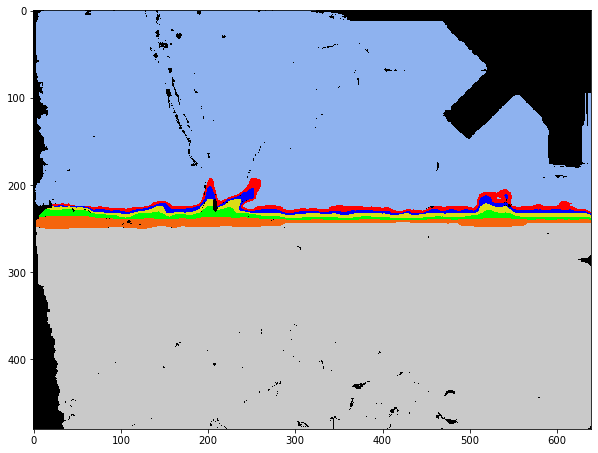

In [14]:
def depth_Z(u,v):
    return npDepth[v][u]


npPointX = np.asarray(range(640))-cx_d
npPointX = np.diag(npPointX)
npPointX = npDepth.dot(npPointX)/ fx_d * (-1)

npPointY = np.asarray(range(480))-cy_d
npPointY = np.diag(npPointY)
theta = 0/180*np.pi
npPointY = npPointY.dot(npDepth)/ fy_d * (-1) 
npPointY = npPointY*np.cos(theta) + npDepth * np.sin(theta) + 410
npPointY = npPointY.astype('float16')

'''depth segmentation'''
npHeight = np.copy(npPointY)
color_seq = {'brown': (0,130,210), 'red':(0,0,255),'yellow':(22,220,220),
                'green':(0,255,0), 'blue':(255,0,0),'black':(0,0,0), 
                'gray':(201,201,201), 'orange':(13,101,245), 'sky':(239,178,142), 'while':(255,255,255)}
npHeight_seg = np.zeros((npDepth.shape[0],npDepth.shape[1],3))

npHeight_seg[npHeight<300]=color_seq['gray']
npHeight_seg[np.logical_and(npHeight<500,npHeight>300)]=color_seq['orange']
npHeight_seg[np.logical_and(npHeight<700,npHeight>500)]=color_seq['green']
npHeight_seg[np.logical_and(npHeight<900,npHeight>700)]=color_seq['yellow']
npHeight_seg[np.logical_and(npHeight<1100,npHeight>900)]=color_seq['blue']
npHeight_seg[np.logical_and(npHeight<1300,npHeight>1100)]=color_seq['red']
npHeight_seg[npHeight>1300]=color_seq['sky']
npHeight_seg[npHeight==410]=color_seq['black']
# npHeight_seg[np.logical_and(npHeight<0.9,npHeight>-0.9)]=(255,255,255)
# print(*(npDepth[np.logical_and(npHeight<0.9,npHeight>-0.9)]))
print(npHeight.dtype)
npHeight_seg = npHeight_seg.astype('uint8')
%matplotlib inline
# fig,ax = plt.subplots(figsize=(10,10))
plt.imshow(cv2.cvtColor(npHeight_seg, cv2.COLOR_BGR2RGB))

(175, 75)

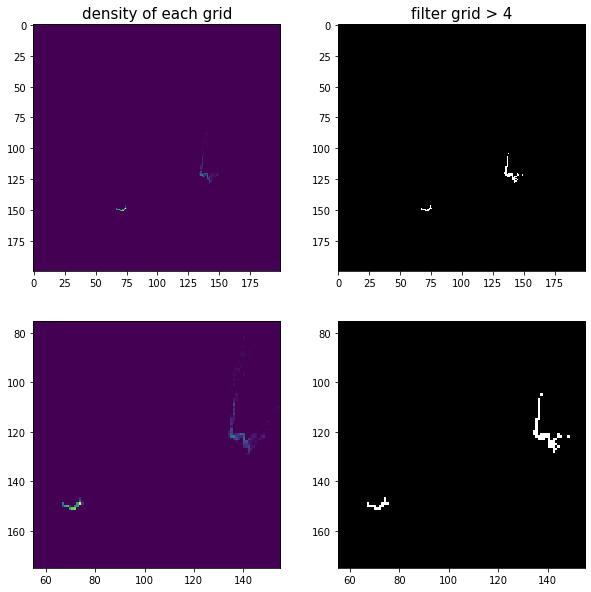

In [23]:
height_layer_tmp = np.logical_and(npHeight<500,npHeight>300)
height_layer = np.logical_and(height_layer_tmp,npHeight!=410)

plane_l1 = np.zeros((int(10/0.05),int(10/0.05)),dtype=np.uint8)

row, column = npDepth.shape
scan_height_ = 10
center_y = row/2
offset = int(center_y - scan_height_/2 );

for v in range(offset, offset+scan_height_,1):#, offset+scan_height_,1
#     if height_layer[v].any() == True:
    for u in range(column):
        if height_layer[v][u] == True:
            z_depth = depth_Z(u,v)

            if (z_depth>50 and z_depth<6000):
                x_depth = (u-cx_d)/fx_d*depth_Z(u,v)
                plane_l1[200-int(z_depth/50)][int(x_depth/50)+100]+=1
                
#     else:
#         pass

fig=plt.figure(figsize=(10,10))
subplot = fig.add_subplot(221)
plt.gca().set_title('density of each grid', fontsize=15)
subplot.imshow(plane_l1)

plane_l1_copy = np.zeros((int(10/0.05),int(10/0.05)), dtype=np.uint8)
plane_l1_copy[plane_l1>4]=255
subplot = fig.add_subplot(222)
plt.gca().set_title('filter grid > 4', fontsize=15)
subplot.imshow(cv2.cvtColor(plane_l1_copy, cv2.COLOR_BGR2RGB))

subplot = fig.add_subplot(223)
subplot.imshow(plane_l1)
plt.xlim((55,155))
plt.ylim((175,75))
subplot = fig.add_subplot(224)
subplot.imshow(cv2.cvtColor(plane_l1_copy, cv2.COLOR_BGR2RGB))
plt.xlim((55,155))
plt.ylim((175,75))

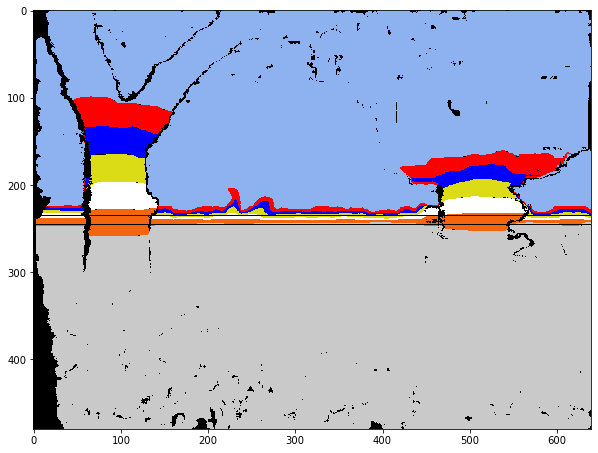

In [29]:
npHeight_seg[height_layer]=255
npHeight_seg[offset]=0
npHeight_seg[offset+scan_height_]=0
fig,ax = plt.subplots(figsize=(10,10))
plt.imshow(cv2.cvtColor(npHeight_seg, cv2.COLOR_BGR2RGB))

(175, 75)

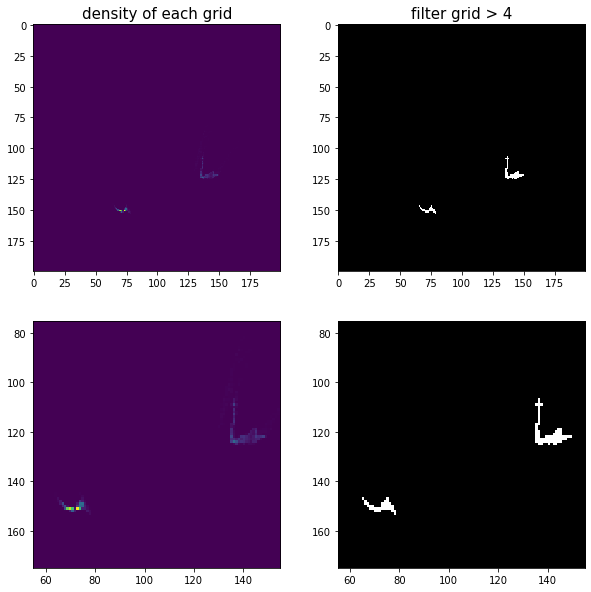

In [26]:
height_layer = np.logical_and(npHeight<700,npHeight>500)

plane_l2 = np.zeros((int(10/0.05),int(10/0.05)),dtype=np.uint8)

row, column = npDepth.shape

for v in range(row):#, offset+scan_height_,1
    if height_layer[v].any() == True:
        for u in range(column):
            if height_layer[v][u] == True:
                z_depth = depth_Z(u,v)
                if (z_depth>50 and z_depth<6000):
                    x_depth = (u-cx_d)/fx_d*depth_Z(u,v)
                    plane_l2[200-int(z_depth/50)][int(x_depth/50)+100]+=1
#         fig,ax=plt.subplots(figsize=(10,10))
#         plt.imshow(plane_l2)
    else:
        pass

fig=plt.figure(figsize=(10,10))
subplot = fig.add_subplot(221)
plt.gca().set_title('density of each grid', fontsize=15)
subplot.imshow(plane_l2)

plane_l2_copy = np.zeros((int(10/0.05),int(10/0.05)), dtype=np.uint8)
plane_l2_copy[plane_l2>4]=255
subplot = fig.add_subplot(222)
plt.gca().set_title('filter grid > 4', fontsize=15)
subplot.imshow(cv2.cvtColor(plane_l2_copy, cv2.COLOR_BGR2RGB))

subplot = fig.add_subplot(223)
subplot.imshow(plane_l2)
plt.xlim((55,155))
plt.ylim((175,75))
subplot = fig.add_subplot(224)
subplot.imshow(cv2.cvtColor(plane_l2_copy, cv2.COLOR_BGR2RGB))
plt.xlim((55,155))
plt.ylim((175,75))

(175, 75)

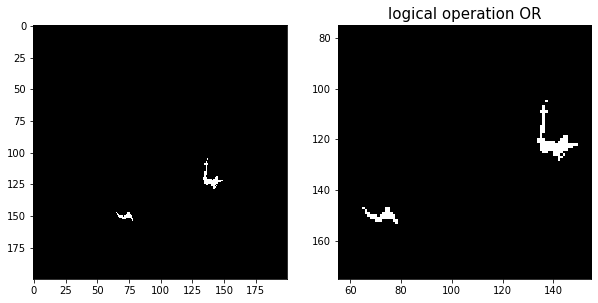

In [32]:
hieght_or = np.zeros((int(10/0.05),int(10/0.05)), dtype=np.uint8)
hieght_or[np.logical_or(plane_l1_copy,plane_l2_copy)]=255

fig = plt.figure(figsize=(10,10))
subplot = fig.add_subplot(121)
subplot.imshow(cv2.cvtColor(hieght_or, cv2.COLOR_BGR2RGB))
subplot = fig.add_subplot(122)
plt.imshow(cv2.cvtColor(hieght_or, cv2.COLOR_BGR2RGB))
plt.title('logical operation OR', fontsize=15)
plt.xlim((55,155))
plt.ylim((175,75))

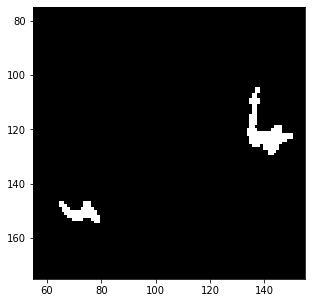

In [33]:
hieght_or = hieght_or.astype('uint8')
kernel = np.ones((2,2), np.uint8)
hieght_or = cv2.dilate(hieght_or,kernel,iterations = 1)

fig.ax = plt.subplots(figsize=(5,5))
plt.xlim((55,155))
plt.ylim((175,75))
plt.imshow(cv2.cvtColor(hieght_or, cv2.COLOR_BGR2RGB))

### find connected component and push into point array A 

In [45]:
num_objects, labels = cv2.connectedComponents(hieght_or)
centre_x_list = []
centre_y_list = []

(141, 3)
116.57478072295099 141.63451203119973 8.193044691603014
117 142 8


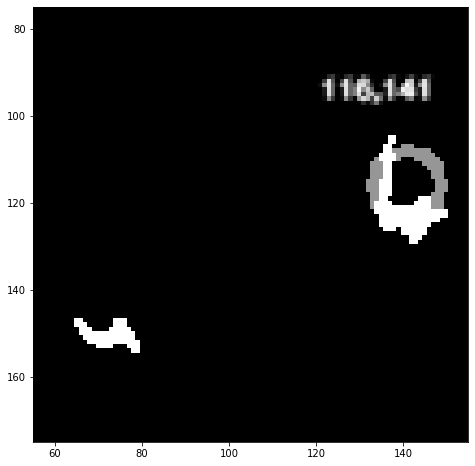

In [46]:
A = []
for x in range(int(10/0.05)):
    for y in range(int(10/0.05)):
        if labels[x][y] == 1:
            A.append(np.array([-x/(x*x+y*y), -y/(x*x+y*y), -1/(x*x+y*y)]))
A = np.asarray(A)
print(A.shape)

k = np.linalg.inv(A.T @ A)
k = k @ A.T
k = k @ np.ones((k.shape[1],1))
# print(k)

centre_x = k[0][0]/(-2)
centre_y = k[1][0]/(-2)
radius_r = np.sqrt(centre_x*centre_x+centre_y*centre_y-k[2][0])
print(centre_x, centre_y, radius_r)
print(int(centre_x+0.5), int(centre_y+0.5), int(radius_r+0.5))

centre_x_list.append(int(centre_x+0.5))
centre_y_list.append(int(centre_y+0.5))

circle_bd = np.zeros(hieght_or.shape, dtype=np.uint8)
cv2.circle(circle_bd,(int(centre_y), int(centre_x)), int(radius_r+0.5), 150, 2)
circle_bd[hieght_or==255]=255
cv2.putText(circle_bd, #numpy array on which text is written
            str(int(centre_x))+','+str(int(centre_y)), #text
            (int(centre_y)-20,int(centre_x)-20), #position at which writing has to start
            cv2.FONT_HERSHEY_SIMPLEX, #font family
            0.2, #font size
            255, #font color
            1, cv2.LINE_AA) #font stroke
fig.ax = plt.subplots(figsize=(8,8))
plt.xlim((55,155))
plt.ylim((175,75))
plt.imshow(cv2.cvtColor(circle_bd, cv2.COLOR_BGR2RGB))

(65, 3)
149.78547826611793 72.10490986093879 4.509057572117545
149 72 5


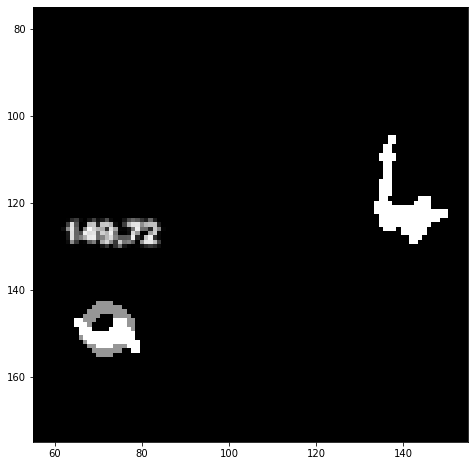

In [47]:
A = []
for x in range(int(10/0.05)):
    for y in range(int(10/0.05)):
        if labels[x][y] == 2:
            A.append(np.array([-x/(x*x+y*y), -y/(x*x+y*y), -1/(x*x+y*y)]))
A = np.asarray(A)
print(A.shape)

k = np.linalg.inv(A.T @ A)
k = k @ A.T
k = k @ np.ones((k.shape[1],1))
# print(k)

centre_x = k[0][0]/(-2)
centre_y = k[1][0]/(-2)
radius_r = np.sqrt(centre_x*centre_x+centre_y*centre_y-k[2][0])
print(centre_x, centre_y, radius_r)
print(int(centre_x), int(centre_y), int(radius_r+0.5))

centre_x_list.append(int(centre_x+0.5))
centre_y_list.append(int(centre_y+0.5))

circle_bd = np.zeros(hieght_or.shape, dtype=np.uint8)
cv2.circle(circle_bd,(int(centre_y), int(centre_x)), int(radius_r+0.5), 150, 2)
circle_bd[hieght_or==255]=255
cv2.putText(circle_bd, #numpy array on which text is written
            str(int(centre_x))+','+str(int(centre_y)), #text
            (int(centre_y)-10,int(centre_x)-20), #position at which writing has to start
            cv2.FONT_HERSHEY_SIMPLEX, #font family
            0.2, #font size
            255, #font color
            1, cv2.LINE_AA) #font stroke
fig.ax = plt.subplots(figsize=(8,8))
plt.xlim((55,155))
plt.ylim((175,75))
plt.imshow(cv2.cvtColor(circle_bd, cv2.COLOR_BGR2RGB))

### load landmark map

In [37]:
directory = '/home/ncslaber/109-2/210725_NTU_leftAreaLibrary/'
bag_name = 'ntu_test3_2021-07-25-18-23-39/'
file_path = directory+bag_name
centroid_filteredNP = np.load(file_path+'centroid_filteredList.npy')
centroid_filteredList = centroid_filteredNP.tolist()
centroid_filteredNP.shape

(4, 2)

In [38]:
with open(file_path+'lat_lon.csv', 'r') as csvfile:
    lat, lng = csv.reader(csvfile, delimiter=',')
lat = float(lat[0])
lng = float(lng[0])

_, _, zone, R = utm.from_latlon(lat, lng)
proj = Proj(proj='utm', zone=zone, ellps='WGS84', preserve_units=False)
utm_x_ref, utm_y_ref = proj(lng, lat)

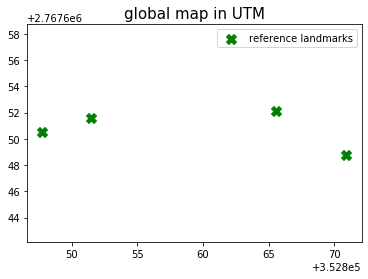

In [321]:
length=1024
map_start_x = 0.5
map_start_y = 0.1
cX_m_ref = (centroid_filteredNP[:,0] - int(length*(1-map_start_y))) *0.05
cY_m_ref = (centroid_filteredNP[:,1] - int(length*(1-map_start_x))) *0.05
cX_utm_ref = cX_m_ref + utm_x_ref
cY_utm_ref = cY_m_ref + utm_y_ref

plt.scatter(cX_utm_ref, cY_utm_ref, c='g', label='reference landmarks', marker='X',s=100)
# plt.scatter(utm_x_ref, utm_y_ref, label='start_recording',c='black')
plt.axis('equal')
plt.title('global map in UTM', fontsize=15)
plt.legend()
plt.show()

### test data

In [42]:
imu_yaw = 160/180*np.pi
lat_lon = [25.017279605923388, 121.54165934652106]
lat_lon_raw = [25.017277333333332, 121.54165866666666]

In [43]:
_, _, zone, R = utm.from_latlon(lat_lon[0], lat_lon[1])
proj = Proj(proj='utm', zone=zone, ellps='WGS84', preserve_units=False)
utm_x_loc, utm_y_loc = proj(lat_lon[1], lat_lon[0])

In [52]:
centre_x_list = np.asarray(centre_x_list)
centre_y_list = np.asarray(centre_y_list)

cX_m_loc = (centre_y_list-100)*0.05
cY_m_loc = (200-centre_x_list)*0.05
cX_utm_loc = cX_m_loc*np.cos(imu_yaw)-cY_m_loc*np.sin(imu_yaw) + utm_x_loc
cY_utm_loc = cX_m_loc*np.sin(imu_yaw)+cY_m_loc*np.cos(imu_yaw)+ utm_y_loc

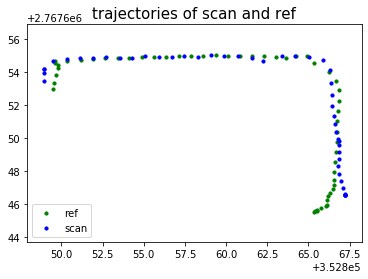

In [338]:
traj = np.load('/home/ncslaber/109-2/210725_NTU_leftAreaLibrary/ntu_test3_2021-07-25-18-23-39/traj_GPS.npy')
traj_x = traj[0,:]
traj_y = traj[1,:]
plt.scatter(traj_x[0:len(traj_x)-653:20], traj_y[0:len(traj_y)-653:20],c='g',s=10, label='ref')

traj = np.load('/home/ncslaber/109-2/210725_NTU_leftAreaLibrary/ntu_test2_2021-07-25-17-42-59/traj_GPS_filtered.npy')
traj_x = traj[0,:]
traj_y = traj[1,:]
plt.scatter(traj_x[0:len(traj_x)-400:100], traj_y[0:len(traj_y)-400:100],c='b',s=10, label='scan')

plt.axis('equal')
plt.title('trajectories of scan and ref', fontsize=15)
plt.legend()
plt.show()

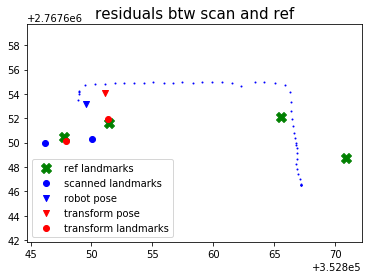

In [326]:
traj = np.load('/home/ncslaber/109-2/210725_NTU_leftAreaLibrary/ntu_test2_2021-07-25-17-42-59/traj_GPS_filtered.npy')
traj_x = traj[0,:]
traj_y = traj[1,:]
plt.scatter(cX_utm_ref, cY_utm_ref, c='g', label='ref landmarks', marker='X',s=100)
# plt.scatter(utm_x_ref, utm_y_ref, label='start_recording',c='black')
plt.scatter(cX_utm_loc, cY_utm_loc, label='scanned landmarks',c='b')
plt.scatter(utm_x_loc, utm_y_loc, label='robot pose',c='b', marker="v")
plt.scatter(traj_x[0:len(traj_x)-400:100], traj_y[0:len(traj_y)-400:100],c='b',s=1)

plt.scatter(utm_x_loc_new, utm_y_loc_new, label='transform pose',c='r', marker="v")
plt.scatter(U_new[0,:], U_new[1,:], label='transform landmarks',c='r')

plt.axis('equal')
plt.title('residuals btw scan and ref', fontsize=15)
plt.legend()
plt.show()

### find rigid transformation

In [42]:
source = np.array([[cX_utm_loc_2, cX_utm_loc],[cY_utm_loc_2, cY_utm_loc]])
dist = np.array([[cX_m[0]*0.05+utm_x_ref, cX_m[1]*0.05+utm_x_ref],[cY_m[0]*0.05+utm_y_ref,cY_m[1]*0.05+utm_y_ref]])

In [89]:
P = np.vstack((cX_utm_ref,cY_utm_ref))
U = np.vstack((cX_utm_loc,cY_utm_loc))
print(P)
print(U)

[[ 352847.76728117  352851.45617005  352865.55140815  352870.92283672]
 [2767650.49778999 2767651.60890111 2767652.14223444 2767648.74223444]]
[[ 352846.18523982  352850.03849723]
 [2767649.97717123 2767650.33059355]]


In [107]:
D = dist.cdist(U.T, P.T)
rows = D.min(axis=1).argsort()
cols = D.argmin(axis=1)[rows]
print(D)
print(rows)
print(list(zip(rows,cols)))

[[ 1.66550254  5.51772126 19.4868154  24.76840264]
 [ 2.27736187  1.90889142 15.61833691 20.94465375]]
[0 1]
[(0, 0), (1, 1)]


In [108]:
Q = np.zeros(U.shape)
for (row, col) in zip(rows, cols):
    Q[:,row] = P[:,col]
print(Q)

[[ 352847.76728117  352851.45617005]
 [2767650.49778999 2767651.60890111]]


In [115]:
# centerize
source = U 
dist = Q
U_bar = np.array([[(source[0,0]+source[0,1])/2],[(source[1,0]+source[1,1])/2]])
Q_bar = np.array([[(dist[0,0]+dist[0,1])/2],[(dist[1,0]+dist[1,1])/2]])

In [119]:
U_bar,Q_bar

(array([[ 352848.11186853],
        [2767650.15388239]]),
 array([[ 352849.61172561],
        [2767651.05334555]]))

In [171]:
X = source-U_bar
Y = dist-Q_bar

In [172]:
S = X @ Y.T
u, s, vh = np.linalg.svd(S)
# check u, vh det
print('det(vh@u.T): ',np.linalg.det(vh@u.T))
tmp = np.array([[1,0],[0,-1]])
R = vh @ tmp @ u.T
t = Q_bar-U_bar
print('R: ',R)
print('theta (deg): ',(np.arccos(R[0,0]))/np.pi*180)
print('translation: ',t)

det(vh@u.T):  -0.9999999999999998
R:  [[ 0.92716369  0.3746565 ]
 [-0.3746565   0.92716369]]
theta (deg):  22.00308373364006
translation:  [[1.49985708]
 [0.89946316]]


In [183]:
A = R.T@X+t
U_new = A+U_bar
utm_x_loc_new = utm_x_loc+t[0]
utm_y_loc_new = utm_y_loc+t[1]

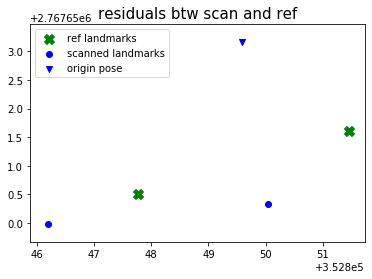

In [322]:
plt.scatter(Q[0,:], Q[1,:], c='g', label='ref landmarks', marker='X', s=100)
plt.scatter(cX_utm_loc, cY_utm_loc, label='scanned landmarks',c='b')
plt.scatter(utm_x_loc, utm_y_loc, label='origin pose',c='b', marker="v")

# plt.scatter(U_new[0,:], U_new[1,:], label='transform landmarks',c='r')
# plt.scatter(utm_x_loc_new, utm_y_loc_new, label='transform pose',c='r', marker="v")

plt.axis('equal')
plt.title('residuals btw scan and ref', fontsize=15)
plt.legend()
plt.show()

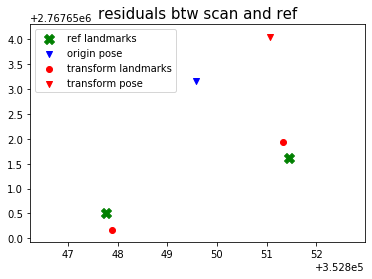

In [323]:
plt.scatter(Q[0,:], Q[1,:], c='g', label='ref landmarks', marker='X', s=100)
# plt.scatter(cX_utm_loc, cY_utm_loc, label='scanned landmarks',c='b')
plt.scatter(utm_x_loc, utm_y_loc, label='origin pose',c='b', marker="v")

plt.scatter(U_new[0,:], U_new[1,:], label='transform landmarks',c='r')
plt.scatter(utm_x_loc_new, utm_y_loc_new, label='transform pose',c='r', marker="v")

plt.axis('equal')
plt.title('residuals btw scan and ref', fontsize=15)
plt.legend()
plt.show()

In [203]:
# calculate residuals
residuals = Q-U_new
residuals = np.absolute(residuals)
resid_scalar = residuals.sum()

### find different negative boundary

(1024, 1024)


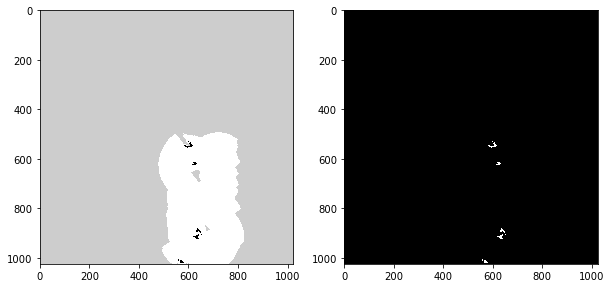

In [239]:
directory = '/home/ncslaber/109-2/210725_NTU_leftAreaLibrary/'
bag_name = 'ntu_test3_2021-07-25-18-23-39/'
file_path = directory+bag_name
shp_path = file_path + 'shapefiles/'

centroid_filteredNP_ref = np.load(file_path+'centroid_filteredList.npy')

raw_pgm = cv2.imread(file_path+"raw_modified.png")
print(raw_pgm.shape[:2])
raw_pgm_binary = np.zeros(raw_pgm.shape[:2],dtype=np.uint8)
raw_pgm_binary[raw_pgm[:,:,0]==0]=255
fig = plt.figure(figsize=(10,10))
subplot = fig.add_subplot(121)
subplot.imshow(cv2.cvtColor(raw_pgm, cv2.COLOR_BGR2RGB))
subplot = fig.add_subplot(122)
subplot.imshow(cv2.cvtColor(raw_pgm_binary, cv2.COLOR_BGR2RGB))

>>>>num_objects: 23
# of points:  (1, 3)
# of points:  (355, 3)
x,y,r:  542.6078308692595 596.7372882922537 11.377591383670445
x,y,r:  543 597 11
# of points:  (2, 3)
# of points:  (1, 3)
# of points:  (2, 3)
# of points:  (1, 3)
# of points:  (178, 3)
x,y,r:  619.0043856969714 621.2551479544054 6.2009260106344355
x,y,r:  619 621 6
# of points:  (1, 3)
# of points:  (3, 3)
# of points:  (2, 3)
# of points:  (1, 3)
# of points:  (1, 3)
# of points:  (185, 3)
x,y,r:  889.7606662888138 638.1735614533536 6.792468815554205
x,y,r:  890 638 7
# of points:  (1, 3)
# of points:  (1, 3)
# of points:  (4, 3)
# of points:  (233, 3)
x,y,r:  913.2732089611673 632.6586831815803 6.7811994136308416
x,y,r:  913 633 7
# of points:  (5, 3)
# of points:  (149, 3)
x,y,r:  1011.3262081189314 565.563869627731 6.403888274797645
x,y,r:  1011 566 6
# of points:  (2, 3)
# of points:  (1, 3)
# of points:  (2, 3)
# of points:  (0,)


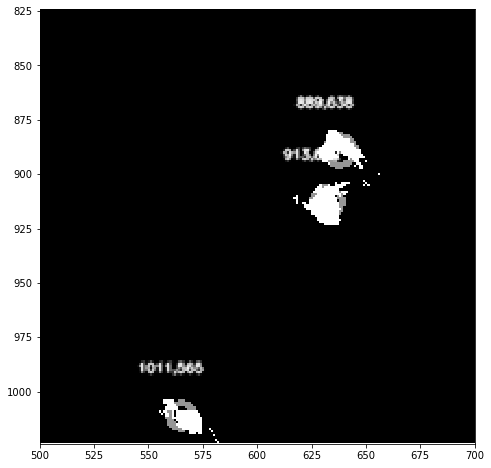

In [253]:
num_objects, labels = cv2.connectedComponents(raw_pgm_binary)
centre_x_list = []
centre_y_list = []
trunk_radius_utm_list = []
circle_bd = np.zeros(raw_pgm_binary.shape, dtype=np.uint8)
print('>>>>num_objects:',num_objects)

for i in range(num_objects):
    A = []
    for x in range(1024):
        for y in range(1024):
            if labels[x][y] == i+1:
                A.append(np.array([-x/(x*x+y*y), -y/(x*x+y*y), -1/(x*x+y*y)]))
    A = np.asarray(A)
    print('# of points: ',A.shape)
    
    if A.shape[0] < 10:
        continue

    k = np.linalg.inv(A.T @ A)
    k = k @ A.T
    k = k @ np.ones((k.shape[1],1))
    # print(k)

    centre_x = k[0][0]/(-2)
    centre_y = k[1][0]/(-2)
    radius_r = np.sqrt(centre_x*centre_x+centre_y*centre_y-k[2][0])
    print('x,y,r: ', centre_x, centre_y, radius_r)
    print('x,y,r: ', int(centre_x+0.5), int(centre_y+0.5), int(radius_r+0.5))
    
    centroid_rawList.append((int(centre_x+0.5),int(centre_y+0.5)))
    centre_x_list.append(int(centre_x+0.5))
    centre_y_list.append(int(centre_y+0.5))
    trunk_radius_utm_list.append(int(radius_r+0.5))

    cv2.circle(circle_bd,(int(centre_y), int(centre_x)), int(radius_r+0.5), 150, 2)
    circle_bd[raw_pgm_binary==255]=255
    cv2.putText(circle_bd, #numpy array on which text is written
                str(int(centre_x))+','+str(int(centre_y)), #text
                (int(centre_y)-20,int(centre_x)-20), #position at which writing has to start
                cv2.FONT_HERSHEY_SIMPLEX, #font family
                0.2, #font size
                255, #font color
                1, cv2.LINE_AA) #font stroke

fig.ax = plt.subplots(figsize=(8,8))
plt.xlim((500,700))
plt.ylim((1024,500))
plt.imshow(cv2.cvtColor(circle_bd, cv2.COLOR_BGR2RGB))

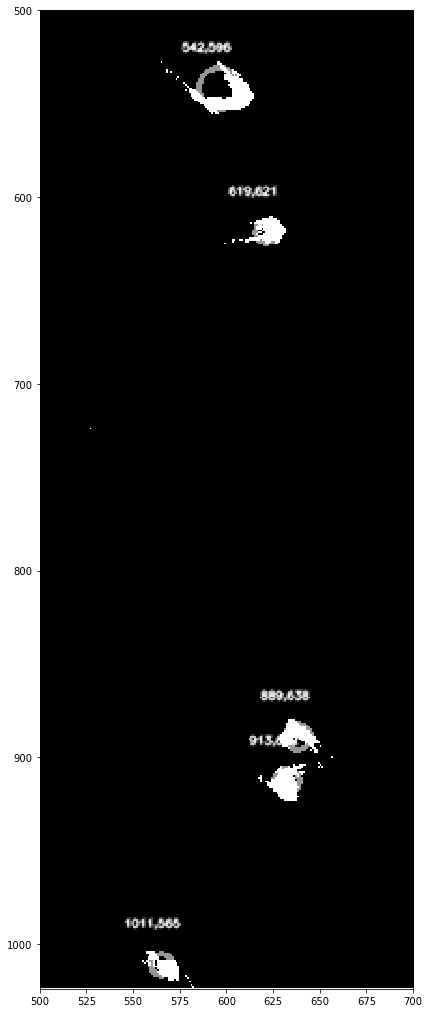

In [288]:
fig.ax = plt.subplots(figsize=(18,18))
plt.xlim((500,700))
plt.ylim((1024,500))
plt.imshow(cv2.cvtColor(circle_bd, cv2.COLOR_BGR2RGB))

In [ ]:
centroid_filteredList = []
while len(centroid_rawList) > 0:
    # centroid_tempList = []
    count = 1
    centroid = centroid_rawList.pop(0)
    # centroid_tempList.append(centroid)

    indexX = centroid[0]
    indexY = centroid[1]
    i = 0 
    # leng = len(centroidList)-1
    while True:
        if i < len(centroid_rawList):
            eDist = distance.euclidean(np.asarray(centroid), np.asarray(centroid_rawList[i]))
            if eDist < 25: # 1m
                centroid_tmp = centroid_rawList.pop(i)

                indexX += centroid_tmp[0]
                indexY += centroid_tmp[1]
                count += 1
                # centroid_tempList.append(centroid_tmp)
                centroid = (indexX/count, indexY/count)
                i -= 1
            i += 1
        else:
            break
    centroid_filteredList.append(centroid)

5
543 597
-18.9 4.25
619 621
-15.1 5.45
913 633
-0.4 6.05
1011 566
4.5 2.7


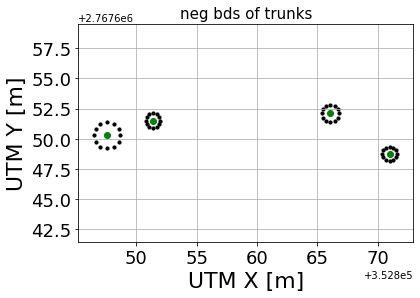

In [286]:
def transform_from_pixel2m(cX, cY,length):  # Here effects initial position
    # cX_m, cY_m = transformation(cX, cY, -0.5*np.pi, -int(length*(1-map_start_y)), int(length*(1-map_start_x)))
    
    cX_m = cX - int(length*(1-0.1))
    cY_m = cY - int(length*(1-0.5))
    
    cX_m /= 20
    cY_m /= 20
    return cX_m, cY_m

''' find neg bds of trunk '''

centre_x_list = np.asarray(centre_x_list)
centre_y_list = np.asarray(centre_y_list)
trunk_radius_utm_list = np.asarray(trunk_radius_utm_list)

number_of_point = 12
piece_rad = np.pi/(number_of_point/2)
print(len(centre_x_list))
for j in range(centre_x_list.shape[0]):
    if j == 2:
        continue
    neg_bd = []
    cX = centre_x_list[j]
    cY = centre_y_list[j]
    print(cX, cY)
    trunk_radius_utm = trunk_radius_utm_list[j]/10
    cX_m, cY_m = transform_from_pixel2m(cX, cY, raw_pgm.shape[0])
    print(cX_m, cY_m)
#     neg_bd.append((cX_m, cY_m))
    for i in range(number_of_point):
        neg_bd.append((cX_m+trunk_radius_utm*np.cos(piece_rad*i)+utm_x_ref, cY_m+trunk_radius_utm*np.sin(piece_rad*i)+utm_y_ref))
    neg_bd = np.asarray(neg_bd)
    plt.scatter(neg_bd[:,0], neg_bd[:,1], c='black', s=10)
    plt.scatter(cX_m+utm_x_ref, cY_m+utm_y_ref, c='g')
plt.ylabel('UTM Y [m]', fontsize=22)
plt.xticks(fontsize=18 )
plt.xlabel('UTM X [m]', fontsize=22)
plt.yticks(fontsize=18 )
plt.grid('on')
plt.axis('equal')
plt.title('neg bds of trunks', fontsize=15)
plt.show()

### test another traj

In [ ]:
imu_yaw = 160/180*np.pi
lat_lon = [25.017279605923388, 121.54165934652106]
lat_lon_raw = [25.017277333333332, 121.54165866666666]
_, _, zone, R = utm.from_latlon(lat_lon[0], lat_lon[1])
proj = Proj(proj='utm', zone=zone, ellps='WGS84', preserve_units=False)
utm_x_loc, utm_y_loc = proj(lat_lon[1], lat_lon[0])

In [ ]:
plt.scatter(cX_utm_ref, cY_utm_ref, c='g', label='ref landmarks', marker='X',s=100)
# plt.scatter(utm_x_ref, utm_y_ref, label='start_recording',c='black')
plt.scatter(cX_utm_loc, cY_utm_loc, label='scanned landmarks',c='r')
plt.scatter(utm_x_loc, utm_y_loc, label='robot pose',c='b', marker="v")

plt.axis('equal')
plt.title('residuals btw scan and ref', fontsize=15)
plt.legend()
plt.show()